<a href="https://colab.research.google.com/github/Vaibhav67979/Facial-Verification-using-Siamese-networks/blob/main/Facial_Verification_using_Siamese_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

## 1.1 Importing Dependencies

In [6]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

## 1.2 Set GPU growth

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# generally not required in colab
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.3 Create Folder Structure

In [8]:
 # Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar lfw dataset

In [7]:
!tar -xf lfw.tgz

In [4]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

## 2.2 Collect Positive and Anchor Classes

In [5]:
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\6a6405ef-048b-11ee-b39e-ced4fb659a15.jpg'

In [39]:
cap = cv2.VideoCapture(0)
type(cap)
if cap.isOpened():
  print("cap")
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screenu
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

cap


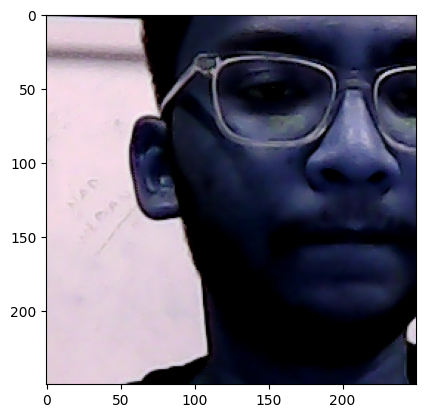

In [35]:
plt.imshow(frame)

# Load and Pre-process the images

## Get image directories

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [10]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\9b5ec8f7-048f-11ee-badc-ced4fb659a15.jpg'


## 3.2 Preprocessing - Scale and Resize

In [11]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [12]:
img = preprocess('data\\anchor\\98e91a44-048f-11ee-a13a-ced4fb659a15.jpg')
img.numpy().max() 


0.9237745

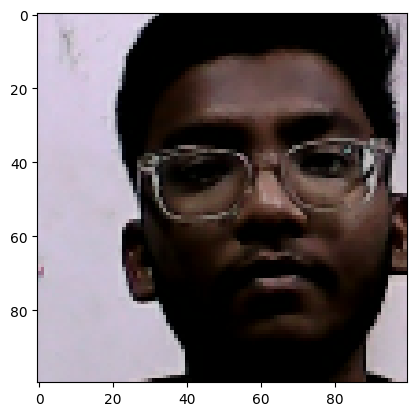

In [13]:
plt.imshow(img)

In [7]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

## 3.3 Create Labelled Dataset

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
samples = data.as_numpy_iterator()
exampple = samples.next()

In [16]:
exampple

(b'data\\anchor\\92bc0dc6-048f-11ee-8c49-ced4fb659a15.jpg',
 b'data\\positive\\1552031c-0490-11ee-a677-ced4fb659a15.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*exampple)

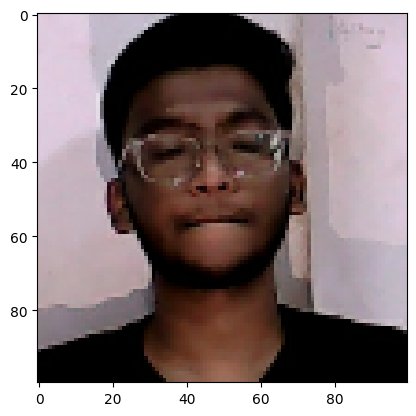

In [19]:
plt.imshow(res[1])

In [20]:
res[2]

1.0

In [21]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [22]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model 

## 4.1 Build Embedding Layer

In [27]:
inp = Input(shape=(100,100,3), name='input_image')

In [28]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [29]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [30]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [31]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [32]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [24]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [25]:
embedding = make_embedding()

embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [33]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [34]:
l1 = L1Dist()

In [35]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

## 4.3 Make Siamese Model

In [36]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [37]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [38]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [39]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [40]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [41]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [42]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [44]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

In [45]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [46]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [67]:
EPOCHS = 50

In [68]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 413s 15s/step

 Epoch 2/50
27/27 [==============================] - 389s 14s/step

 Epoch 3/50
27/27 [==============================] - 387s 14s/step

 Epoch 4/50
27/27 [==============================] - 394s 15s/step

 Epoch 5/50
27/27 [==============================] - 392s 15s/step

 Epoch 6/50
27/27 [==============================] - 392s 15s/step

 Epoch 7/50
27/27 [==============================] - 391s 14s/step

 Epoch 8/50
27/27 [==============================] - 392s 15s/step

 Epoch 9/50
27/27 [==============================] - 394s 15s/step

 Epoch 10/50
27/27 [==============================] - 392s 15s/step

 Epoch 11/50
27/27 [==============================] - 391s 14s/step

 Epoch 12/50
27/27 [==============================] - 390s 14s/step

 Epoch 13/50
27/27 [======

KeyboardInterrupt: 

In [69]:
siamese_model.save('siamesemodel.h5')

# Evaulate Model

## 6.1 Import metrics

In [47]:
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [68]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [69]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 773ms/step


array([[0.5006086 ],
       [0.5005269 ],
       [0.49934715],
       [0.5014637 ],
       [0.5001875 ],
       [0.50080657],
       [0.50145686],
       [0.5011385 ],
       [0.5015896 ],
       [0.50172764],
       [0.5011301 ],
       [0.5018977 ],
       [0.5017676 ],
       [0.50076705],
       [0.5010409 ],
       [0.5012469 ]], dtype=float32)

In [70]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [71]:
y_true

array([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [72]:
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [73]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.46666667

## Results

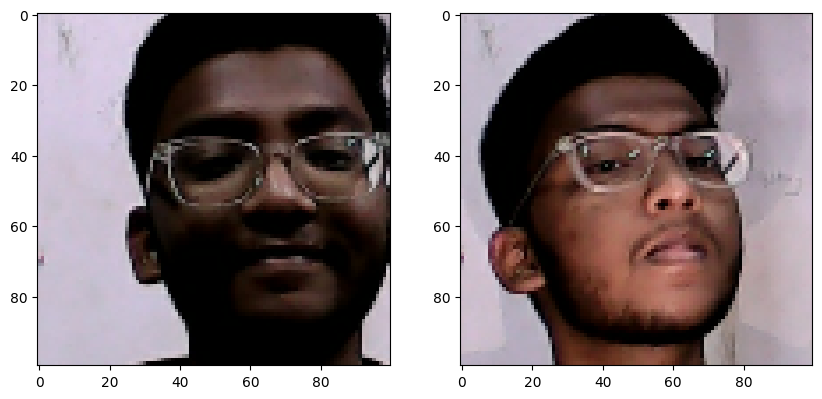

In [74]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [55]:
# Save weights
#siamese_model.save('siamesemodel.h5')
L1Dist

__main__.L1Dist

In [57]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [75]:

# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 1s 788ms/step


array([[1.0000000e+00],
       [9.9999976e-01],
       [4.8335274e-08],
       [1.0000000e+00],
       [1.1192615e-07],
       [9.9999988e-01],
       [5.9794969e-10],
       [6.3979475e-09],
       [9.9999988e-01],
       [6.7965033e-08],
       [2.1372477e-09],
       [9.9999970e-01],
       [1.2644020e-09],
       [1.0690438e-08],
       [9.9999964e-01],
       [7.6318640e-10]], dtype=float32)

In [59]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [82]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [83]:
os.listdir(os.path.join('application_data', 'verification_images'))

['030b6b76-0490-11ee-a61c-ced4fb659a15 - Copy - Copy.jpg',
 '030b6b76-0490-11ee-a61c-ced4fb659a15.jpg',
 '039d51e1-0490-11ee-b317-ced4fb659a15 - Copy.jpg',
 '046ee522-0490-11ee-9495-ced4fb659a15 - Copy - Copy.jpg',
 '053a592d-0490-11ee-ad9b-ced4fb659a15 - Copy - Copy.jpg',
 '060d91af-0490-11ee-906a-ced4fb659a15 - Copy.jpg',
 '060d91af-0490-11ee-906a-ced4fb659a15.jpg',
 '072cb5df-0490-11ee-8512-ced4fb659a15 - Copy.jpg',
 '075de47d-0490-11ee-b7db-ced4fb659a15 - Copy - Copy.jpg',
 '07f638ef-0490-11ee-9209-ced4fb659a15.jpg',
 '085fe100-0490-11ee-89d5-ced4fb659a15 - Copy - Copy.jpg',
 '0887c0a0-0490-11ee-938b-ced4fb659a15.jpg',
 '08c4b7b1-0490-11ee-a081-ced4fb659a15.jpg',
 '09b66d54-0490-11ee-ad80-ced4fb659a15.jpg',
 '109dd89c-0490-11ee-ac6a-ced4fb659a15 - Copy.jpg',
 '10c1274b-0490-11ee-9f9e-ced4fb659a15 - Copy - Copy - Copy - Copy.jpg',
 '10c1274b-0490-11ee-9f9e-ced4fb659a15 - Copy.jpg',
 '112aa8a3-0490-11ee-b08b-ced4fb659a15.jpg',
 '114e03b3-0490-11ee-bda5-ced4fb659a15 - Copy - Copy.jpg'

In [84]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [85]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\030b6b76-0490-11ee-a61c-ced4fb659a15 - Copy - Copy.jpg
application_data\verification_images\030b6b76-0490-11ee-a61c-ced4fb659a15.jpg
application_data\verification_images\039d51e1-0490-11ee-b317-ced4fb659a15 - Copy.jpg
application_data\verification_images\046ee522-0490-11ee-9495-ced4fb659a15 - Copy - Copy.jpg
application_data\verification_images\053a592d-0490-11ee-ad9b-ced4fb659a15 - Copy - Copy.jpg
application_data\verification_images\060d91af-0490-11ee-906a-ced4fb659a15 - Copy.jpg
application_data\verification_images\060d91af-0490-11ee-906a-ced4fb659a15.jpg
application_data\verification_images\072cb5df-0490-11ee-8512-ced4fb659a15 - Copy.jpg
application_data\verification_images\075de47d-0490-11ee-b7db-ced4fb659a15 - Copy - Copy.jpg
application_data\verification_images\07f638ef-0490-11ee-9209-ced4fb659a15.jpg
application_data\verification_images\085fe100-0490-11ee-89d5-ced4fb659a15 - Copy - Copy.jpg
application_data\verification_images\0887c0a0-0490-

## 8.2 OpenCV Real Time Verification

In [107]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 222ms/step
True
1/1 [==============================] - 0s 207ms/step
False
1/1 [==============================] - 0s 215ms/step
True
1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 221ms/step
True
1/1 [==============================] - 0s 205ms/step
False
1/1 [==============================] - 0s 221ms/step
False
1/1 [==============================] - 0s 205ms/step


1/1 [==============================] - 0s 205ms/step
False
1/1 [==============================] - 0s 206ms/step
False
1/1 [==============================] - 0s 223ms/step
True
1/1 [==============================] - 0s 221ms/step


1/1 [==============================] - 0s 205ms/step
False
1/1 [==============================] - 0s 223ms/step
True
1/1 [==============================] - 0s 221ms/step
False
1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 205ms/step
False
1/1 [==============================] - 0s 205ms/step
True
1/1 [==============================] - 0s 206ms/step
False
1/1 [==============================] - 0s 205ms/step


1/1 [==============================] - 0s 210ms/step
True
1/1 [==============================] - 0s 205ms/step
False
1/1 [==============================] - 0s 221ms/step
False
1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 221ms/step
False
1/1 [==============================] - 0s 222ms/step
False
1/1 [==============================] - 0s 221ms/step
False
1/1 [==============================] - 0s 221ms/step


1/1 [==============================] - 0s 222ms/step
False
1/1 [==============================] - 0s 200ms/step
True


In [108]:
np.sum(np.squeeze(results) > 0.9)

44

0.88